# Predicting results

## Imports

In [24]:
import mysql.connector as sql
import pandas as pd
import numpy as np
from datetime import date, timedelta

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display, HTML
from tqdm import tqdm

## Definitions

In [25]:
from_year=2016
to_year=2018
streak_days_long=100
streak_days_short=20

In [26]:
def get_prev_matches_numbers(date_start, date_end, team_id, df):
    dfteam_previous = df[((df["team_home_id"]==team_id) | (df["team_away_id"]==team_id)) & (df["kickoff_time"]<date_end) & (df["kickoff_time"]>date_start)].copy()
    if len(dfteam_previous) == 0:
        win_rate = 0.
        score_diff_avg = 0.
    else:
        dfteam_previous["score_team"] = dfteam_previous.apply(lambda x: x["score_home"] if x["team_home_id"]==team_id else x["score_away"], axis=1)
        dfteam_previous["score_oponent"] = dfteam_previous.apply(lambda x: x["score_away"] if x["team_home_id"]==team_id else x["score_home"], axis=1)
        dfteam_previous["won"] = dfteam_previous["score_team"] > dfteam_previous["score_oponent"]
        dfteam_previous["score_diff"] = dfteam_previous["score_team"] - dfteam_previous["score_oponent"]
        win_rate = float(dfteam_previous["won"].sum()) / len(dfteam_previous)
        score_diff_avg = dfteam_previous["score_diff"].mean()
    return win_rate, score_diff_avg

In [27]:
def calculate_variables_last_X_train(df_games, last_X_days):
    # for each game add results of last ones
    win_rate_home_list = []
    win_rate_away_list = []
    score_diff_avg_home_list = []
    score_diff_avg_away_list = []
    for i, row in tqdm(df_games.iterrows()):
        date_end = row["kickoff_time"]
        date_start = date_end - timedelta(days=last_X_days)
        # For the home team
        team_id = row["team_home_id"]
        # print("Home team:", team_id)
        win_rate_home, score_diff_avg_home = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_home_list += [win_rate_home]
        score_diff_avg_home_list += [score_diff_avg_home]
        # For the away team
        team_id = row["team_away_id"]
        # print("Away team:", team_id)
        win_rate_away, score_diff_avg_away = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_away_list += [win_rate_away]
        score_diff_avg_away_list += [score_diff_avg_away]

    # add historical to df
    df_games["win_rate_home_last"+str(last_X_days)] = win_rate_home_list
    df_games["score_diff_avg_home_last"+str(last_X_days)] = score_diff_avg_home_list
    df_games["win_rate_away_last"+str(last_X_days)] = win_rate_away_list
    df_games["score_diff_avg_away_last"+str(last_X_days)] = score_diff_avg_away_list

    return df_games

In [28]:
def calculate_variables_last_X_predict(df_predict, df_games, last_X_days):
    # for each game add results of last ones
    win_rate_home_list = []
    win_rate_away_list = []
    score_diff_avg_home_list = []
    score_diff_avg_away_list = []
    for i, row in tqdm(df_predict.iterrows()):
        date_end = row["kickoff_time"]
        date_start = date_end - timedelta(days=last_X_days)
        # For the home team
        team_id = row["team_home_id"]
        # print("Home team:", team_id)
        win_rate_home, score_diff_avg_home = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_home_list += [win_rate_home]
        score_diff_avg_home_list += [score_diff_avg_home]
        # For the away team
        team_id = row["team_away_id"]
        # print("Away team:", team_id)
        win_rate_away, score_diff_avg_away = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_away_list += [win_rate_away]
        score_diff_avg_away_list += [score_diff_avg_away]

    # add historical to df
    df_predict["win_rate_home_last" + str(last_X_days)] = win_rate_home_list
    df_predict["score_diff_avg_home_last" + str(last_X_days)] = score_diff_avg_home_list
    df_predict["win_rate_away_last" + str(last_X_days)] = win_rate_away_list
    df_predict["score_diff_avg_away_last" + str(last_X_days)] = score_diff_avg_away_list

    return df_predict

## Loading data from db

In [29]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_games = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

#print(df_games.shape)
#print(df_games.columns)
#df_games.head()

## Correlations

In [30]:
#correlation matrix
#corrmat = df_games.corr()
#f, ax = plt.subplots(figsize=(20,18))
#sns.heatmap(corrmat, square=True, cmap=sns.diverging_palette(240, 10, as_cmap=True))
#plt.show()

In [31]:
#cols_aux = [c for c in df_games.columns if (c.startswith("score") and not c.endswith("extra"))]
#print(cols_aux)
#sns.set(style="ticks", color_codes=True)
#sns.pairplot(df_games[cols_aux])
#plt.show()

## Preprocessing

In [32]:
# cols to keep
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_games.columns if c not in cols_to_keep]
df_games.drop(cols_to_del, axis=1, inplace=True)

# check if nulls
#print("Number of nulls in df:", df_games.isnull().sum().max())

# checking amount of times a home team won
#win_home = df_games["score_away"] < df_games["score_home"]
#print("Home Team Win percentage: {0:.1f}%".format(100 * win_home.values.sum() / len(win_home)))

# create score difference feature
df_games["score_difference"] = df_games["score_home"] - df_games["score_away"]
#print("Mean of score difference:", df_games["score_difference"].mean())

df_games=calculate_variables_last_X_train(df_games, streak_days_long)
df_games=calculate_variables_last_X_train(df_games, streak_days_short)
df_games.head()


793it [00:19, 39.73it/s]
793it [00:16, 49.50it/s]


,team_home_id,team_away_id,season,journey,score_home,score_away,kickoff_time,referee_1,score_difference,win_rate_home_last100,score_diff_avg_home_last100,win_rate_away_last100,score_diff_avg_away_last100,win_rate_home_last20,score_diff_avg_home_last20,win_rate_away_last20,score_diff_avg_away_last20
0,1,9,2018,1,88,73,2018-09-30 19:15:00,Jiménez Trujillo,15,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,18,1,2018,2,70,88,2018-10-05 20:45:00,Antonio Conde,-18,0.000000,-13.000000,1.000000,15.000000,0.0,-13.0,1.0,15.0
2,3,2,2018,12,78,73,2018-12-16 19:30:00,Carlos Peruga,5,0.727273,6.000000,0.909091,13.181818,0.0,-7.0,1.0,4.0
3,17,10,2018,12,83,68,2018-12-16 19:30:00,M.A. Pérez Pérez,15,0.272727,-4.454545,0.545455,-3.090909,0.0,-24.0,1.0,7.0
4,4,16,2018,12,76,87,2018-12-15 20:30:00,Daniel Hierrezuelo,-11,0.454545,-3.636364,0.181818,-10.545455,0.0,-19.0,0.0,-14.0


In [33]:
"""df_games_inverse = df_games.copy()
for c in df_games_inverse.columns:
    if "home" in c:
        df_games_inverse[c.replace("home", "away")] = df_games[c]
    if "away" in c:
        df_games_inverse[c.replace("away", "home")] = df_games[c]
df_games_inverse["score_difference"] = -df_games["score_difference"]        
df_games_inverse.head()"""

'df_games_inverse = df_games.copy()\nfor c in df_games_inverse.columns:\n    if "home" in c:\n        df_games_inverse[c.replace("home", "away")] = df_games[c]\n    if "away" in c:\n        df_games_inverse[c.replace("away", "home")] = df_games[c]\ndf_games_inverse["score_difference"] = -df_games["score_difference"]        \ndf_games_inverse.head()'

## Regression

Rows for training: 622
Rows for test: 171
Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')


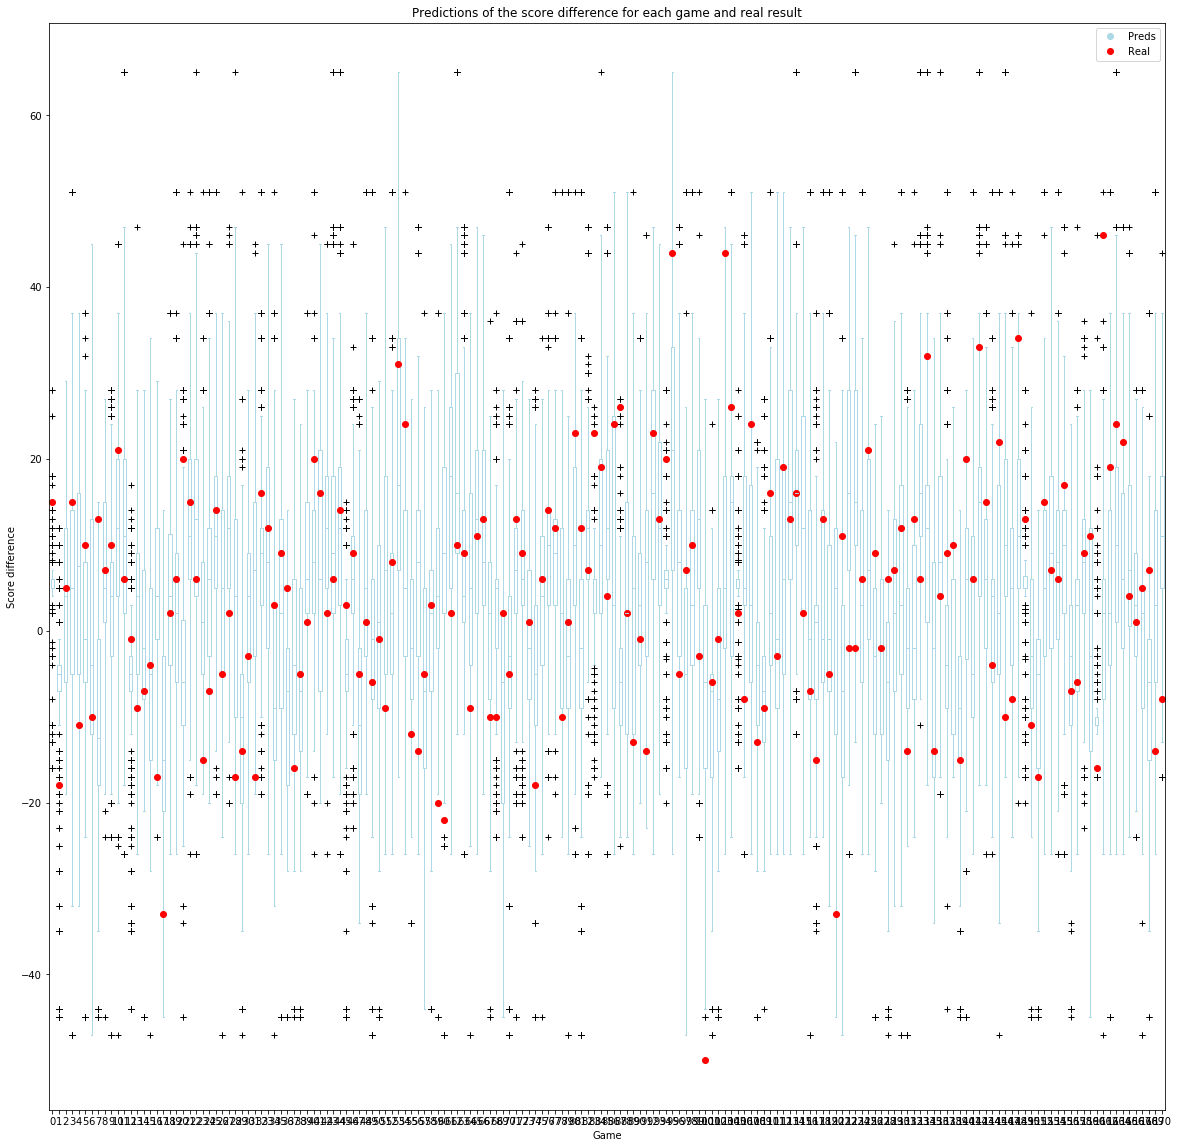

Percentage of the times the mean was positive: 0.7134502923976608
Percentage of the times the median was positive: 0.7017543859649122
Percentage of the times the score was in the given interval: 93.5672514619883%
Mean absolute error: 10.66528835978836 points
Percentage of the times the winner was correct: 0.672514619883041%


In [56]:
#df_final = pd.concat([df_games, df_games_inverse], ignore_index = True)
df_final = df_games.copy()
df_final.drop(["score_home", "score_away", "journey", "kickoff_time", "referee_1"], axis=1, inplace=True)
#df_final = df_final[["win_rate_home", "score_diff_avg_home", "win_rate_away", "score_diff_avg_away", "season", "score_difference"]]

# Years for train // Years for test (generally 2016-2017 and 2018)
train = df_final[df_final["season"]<to_year]
test = df_final[df_final["season"]>=to_year]

print("Rows for training:", len(train))
print("Rows for test:", len(test))

X_train = train.drop(['score_difference', "season"], axis=1)
y_train = train['score_difference']
X_test = test.drop(['score_difference', "season"], axis=1)
y_test = test['score_difference'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Train algorithm
print(X_train.columns)
model = RandomForestRegressor(n_estimators=1000, random_state=20, max_depth=None, n_jobs=-1)
model.fit(X_train, y_train)

#print(model.feature_importances_)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(X_test)
df_preds_estimators = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the real value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(X_test)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(y_test, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each game and real result")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' ')], ['Preds', 'Real'])
plt.show()

# Some conclusions about the intervals
df_preds_estimators["Upper"] = df_preds_estimators.apply(
    lambda x: np.percentile(x, 75) + 1.5 * (np.percentile(x, 75) - np.percentile(x, 25)), axis=1)
df_preds_estimators["Lower"] = df_preds_estimators.apply(
    lambda x: np.percentile(x, 25) - 1.5 * (np.percentile(x, 75) - np.percentile(x, 25)), axis=1)
df_preds_estimators["Real"] = y_test

mean_aux = df_preds_estimators.apply(lambda x: 1 if x.mean() >= 0 else 0, axis=1)
print("Percentage of the times the mean was positive:", mean_aux.mean())
median_aux=df_preds_estimators.apply(lambda x: 1 if np.percentile(x, 50)>=0 else 0, axis=1)
print("Percentage of the times the median was positive:", median_aux.mean())

df_preds_estimators["score_in_range?"] = (df_preds_estimators["Real"] >= df_preds_estimators["Lower"]) \
                                         & (df_preds_estimators["Real"] <= df_preds_estimators["Upper"])
print("Percentage of the times the score was in the given interval: {}%".format(
    100 * float(df_preds_estimators["score_in_range?"].sum()) / len(df_preds_estimators)))


# Predicting score directly
y_pred = model.predict(X_test)

d = {'Real': y_test, 'Pred': y_pred}
df_res = pd.DataFrame(data=d)
df_res["winner_correct?"] = np.sign(df_res["Real"]) == np.sign(df_res["Pred"])
print("Mean absolute error: {} points".format(metrics.mean_absolute_error(y_test, y_pred)))
print("Percentage of the times the winner was correct: {}%".format(
    float(df_res["winner_correct?"].sum()) / len(df_res)))

## Classification

In [11]:
"""#df_final = pd.concat([df_games, df_games_inverse], ignore_index = True)
df_final = df_games.copy()
df_final["winner"] = df_final["score_difference"] > 0 
df_final.drop(["score_home", "score_away", "journey", "kickoff_time", "referee_1", "score_difference"], axis=1, inplace=True)
#df_final = df_final[["win_rate_home", "score_diff_avg_home", "win_rate_away", "score_diff_avg_away", "season", "score_difference"]]

# Years for train // Years for test (generally 2016-2017 and 2018)
train = df_final[df_final["season"]<to_year]
test = df_final[df_final["season"]>=to_year]

print("Rows for training:", len(train))
print("Rows for test:", len(test))

X_train = train.drop(['winner', "season"], axis=1)
y_train = train['winner']
X_test = test.drop(['winner', "season"], axis=1)
y_test = test['winner'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Train algorithm
print(X_train.columns)
model = RandomForestClassifier(n_estimators=1000, random_state=20, max_depth=None, n_jobs=-1)
model.fit(X_train, y_train)

#print(model.feature_importances_)

# Predicting score directly
y_pred = model.predict(X_test)

d = {'Real': y_test, 'Pred': y_pred}
df_res = pd.DataFrame(data=d)
df_res["winner_correct?"] = df_res["Real"] == df_res["Pred"]
print("Accuracy: {} points".format(df_res["winner_correct?"].mean()))"""

Rows for training: 622
Rows for test: 171
Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
Accuracy: 0.6549707602339181 points


## Predict next journey

In [36]:
# Load csv aux
next_journey_matches_df = pd.read_csv("caca.csv", sep=",", encoding="utf-8", parse_dates=["kickoff_time"])
next_journey_matches_df

,team_home,team_home_id,team_away,team_away_id,season,kickoff_time,journey
0,VALENCIA BASKET CLUB,18,MONBUS OBRADOIRO,5,2018,2019-02-09 18:00:00,20
1,BARÇA LASSA,2,MONTAKIT FUENLABRADA,8,2018,2019-02-09 18:00:00,20
2,IBEROSTAR TENERIFE,9,SAN PABLO BURGOS,11,2018,2019-02-09 20:30:00,20
3,UNICAJA,3,BAXI MANRESA,12,2018,2019-02-09 20:30:00,20
4,MOVISTAR ESTUDIANTES,7,MORABANC ANDORRA,4,2018,2019-02-10 12:30:00,20
5,CAFÉS CANDELAS BREOGÁN,15,UCAM MURCIA CB,14,2018,2019-02-10 17:00:00,20
6,DIVINA SEGUROS JOVENTUT,10,TECNYCONTA ZARAGOZA,13,2018,2019-02-10 19:30:00,20
7,REAL MADRID,1,KIROLBET BASKONIA,6,2018,2019-02-10 19:30:00,20
8,HERBALIFE GRAN CANARIA,17,DELTECO GBC,16,2018,2019-02-10 19:30:00,20


9it [00:00, 36.75it/s]
9it [00:00, 50.15it/s]


Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
[ 8.64   11.063  13.204  10.41   -1.236   7.686   8.9485  8.925   6.404 ]
           0     1     2     3     4     5     6     7     8
Est00   28.0   4.0  22.0  24.0 -11.0   4.0 -20.0  13.0   3.0
Est01   14.0  14.0  12.0  25.0   7.0   9.0 -12.0  12.0 -26.0
Est02   24.0  16.0  12.0  11.0 -20.0   5.0  13.0 -19.0   5.0
Est03   -8.0   2.0 -26.0  21.0   2.0   4.0   9.0  12.0  28.0
Est04   15.0  -1.0   5.0  13.0   8.0  20.0  13.0   4.0  25.0
Est05   46.0  45.0   4.0  18.0   4.0  51.0  -9.0  -1.0  34.0
Est06   13.0 -18.0   9.0  13.0  -3.0 -10.0  13.0  10.0  14.0
Est07   -7.0  47.0   9.0   6.0  16.0  11.0   2.0   6.0   5.0
Est08   -6.0  46.0   4.0 -14.0 -11.0  -6.0  21.0  -9.0   3.0
Est09 

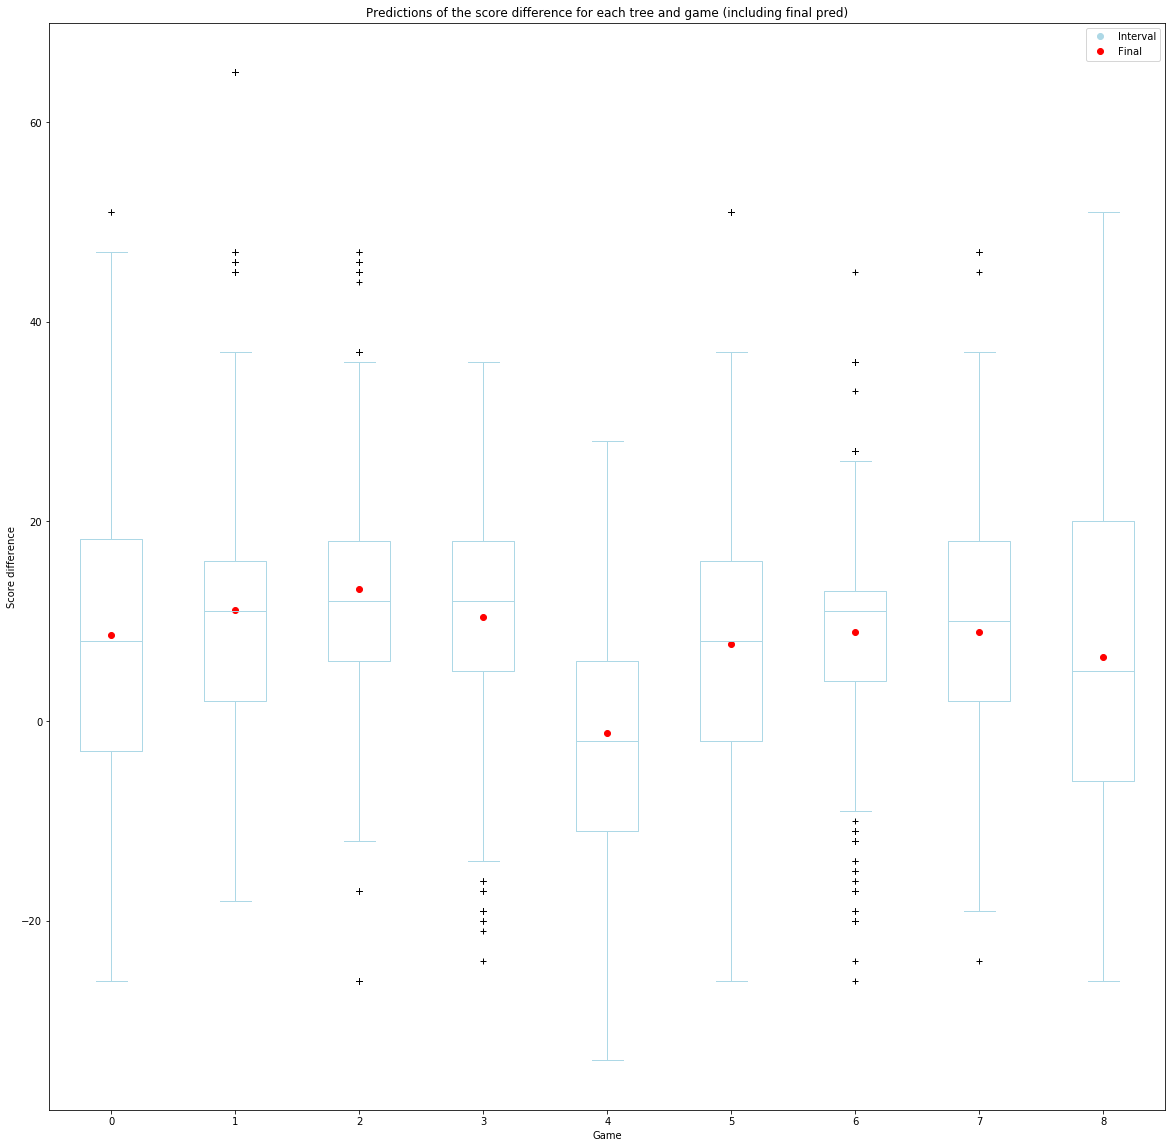

In [59]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_aux = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

# cols to keep for df_games
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_aux.columns if c not in cols_to_keep]
df_aux.drop(cols_to_del, axis=1, inplace=True)

# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(next_journey_matches_df, df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds = model.predict(df_predict)
print(preds)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(df_predict)
df_preds_estimators = pd.DataFrame(data=preds_estimators)
print(df_preds_estimators.transpose())

# Plotting the intervals and the predicted value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' ')], ['Interval', 'Final'])
plt.show()



In [81]:
# Analyze real madrid interval
rm_interval = df_preds_estimators.iloc[7]
aux = [1 if sd >=5.99 else 0 for sd in rm_interval]
print("Prob of being in that interval:", np.mean(aux)*100, "%")
print("Estimated bet ratio:", 1/np.mean(aux))
aux = [1 if sd <=-5.99 else 0 for sd in rm_interval]
print("Prob of being in that interval:", np.mean(aux)*100, "%")
print("Estimated bet ratio:", 1/np.mean(aux))
aux = [1 if abs(sd) < 5.99 else 0 for sd in rm_interval]
print("Prob of being in that interval:", np.mean(aux)*100, "%")
print("Estimated bet ratio:", 1/np.mean(aux))


Prob of being in that interval: 60.0 %
Estimated bet ratio: 1.6666666666666667
Prob of being in that interval: 11.0 %
Estimated bet ratio: 9.090909090909092
Prob of being in that interval: 28.999999999999996 %
Estimated bet ratio: 3.4482758620689657


In [113]:
# Analyze real madrid interval
rm_preds = df_preds_estimators.iloc[7]
inits_intervals=[1, 3, 7, 10, 14, 17, 21]
inits_intervals =  [-i for i in inits_intervals[::-1]] + inits_intervals

prev = inits_intervals[0]
aux = [1 if sd <=(prev+0.001) else 0 for sd in rm_preds]
print("Prob of being in the interval Inf to {}: {}%".format(prev, np.mean(aux)*100))
print("Estimated fair bet ratio for the interval Inf to {}: {}".format(prev, 1/np.mean(aux)))

for i in range(1, len(inits_intervals)):
    prev = inits_intervals[i-1] if inits_intervals[i-1]>0 else inits_intervals[i-1]+1
    end = inits_intervals[i]-1 if inits_intervals[i]>0 else inits_intervals[i]
    aux = [1 if sd >=(prev-0.001) and sd<(end+0.001) else 0 for sd in rm_preds]
    print("Prob of being in the interval {} to {}: {}%".format(prev, end, np.mean(aux)*100))
    print("Estimated fair bet ratio for the interval {} to {}: {}".format(prev, end, 1/np.mean(aux)))

prev = inits_intervals[-1]
aux = [1 if sd >=(prev-0.001) else 0 for sd in rm_preds]
print("Prob of being in the interval {} to Inf: {}%".format(prev, np.mean(aux)*100))
print("Estimated fair bet ratio for the interval {} to Inf: {}".format(prev, 1/np.mean(aux)))

Prob of being in the interval Inf to -21: 0.1%
Estimated fair bet ratio for the interval Inf to -21: 1000.0
Prob of being in the interval -20 to -17: 1.0999999999999999%
Estimated fair bet ratio for the interval -20 to -17: 90.90909090909092
Prob of being in the interval -16 to -14: 0.1%
Estimated fair bet ratio for the interval -16 to -14: 1000.0
Prob of being in the interval -13 to -10: 4.2%
Estimated fair bet ratio for the interval -13 to -10: 23.809523809523807
Prob of being in the interval -9 to -7: 4.7%
Estimated fair bet ratio for the interval -9 to -7: 21.27659574468085
Prob of being in the interval -6 to -3: 5.2%
Estimated fair bet ratio for the interval -6 to -3: 19.23076923076923
Prob of being in the interval -2 to -1: 4.2%
Estimated fair bet ratio for the interval -2 to -1: 23.809523809523807
Prob of being in the interval 0 to 0: 0.0%


C:\Users\ricardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


Estimated fair bet ratio for the interval 0 to 0: inf
Prob of being in the interval 1 to 2: 7.3999999999999995%
Estimated fair bet ratio for the interval 1 to 2: 13.513513513513514
Prob of being in the interval 3 to 6: 17.2%
Estimated fair bet ratio for the interval 3 to 6: 5.813953488372094
Prob of being in the interval 7 to 9: 4.1000000000000005%
Estimated fair bet ratio for the interval 7 to 9: 24.390243902439025
Prob of being in the interval 10 to 13: 22.8%
Estimated fair bet ratio for the interval 10 to 13: 4.385964912280701
Prob of being in the interval 14 to 16: 2.4%
Estimated fair bet ratio for the interval 14 to 16: 41.666666666666664
Prob of being in the interval 17 to 20: 9.4%
Estimated fair bet ratio for the interval 17 to 20: 10.638297872340425
Prob of being in the interval 21 to Inf: 17.1%
Estimated fair bet ratio for the interval 21 to Inf: 5.847953216374268


In [114]:
# Analyze real madrid interval
rm_preds = df_preds_estimators.iloc[7]
inits_intervals=[1, 6, 11, 16, 21, 26, 31]
inits_intervals =  [-i for i in inits_intervals[::-1]] + inits_intervals

prev = inits_intervals[0]
aux = [1 if sd <=(prev+0.001) else 0 for sd in rm_preds]
print("Prob of being in the interval Inf to {}: {}%".format(prev, np.mean(aux)*100))
print("Estimated fair bet ratio for the interval Inf to {}: {}".format(prev, 1/np.mean(aux)))

for i in range(1, len(inits_intervals)):
    prev = inits_intervals[i-1] if inits_intervals[i-1]>0 else inits_intervals[i-1]+1
    end = inits_intervals[i]-1 if inits_intervals[i]>0 else inits_intervals[i]
    aux = [1 if sd >=(prev-0.001) and sd<(end+0.001) else 0 for sd in rm_preds]
    print("Prob of being in the interval {} to {}: {}%".format(prev, end, np.mean(aux)*100))
    print("Estimated fair bet ratio for the interval {} to {}: {}".format(prev, end, 1/np.mean(aux)))

prev = inits_intervals[-1]
aux = [1 if sd >=(prev-0.001) else 0 for sd in rm_preds]
print("Prob of being in the interval {} to Inf: {}%".format(prev, np.mean(aux)*100))
print("Estimated fair bet ratio for the interval {} to Inf: {}".format(prev, 1/np.mean(aux)))

Prob of being in the interval Inf to -31: 0.0%


C:\Users\ricardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


Estimated fair bet ratio for the interval Inf to -31: inf
Prob of being in the interval -30 to -26: 0.0%


C:\Users\ricardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


Estimated fair bet ratio for the interval -30 to -26: inf
Prob of being in the interval -25 to -21: 0.1%
Estimated fair bet ratio for the interval -25 to -21: 1000.0
Prob of being in the interval -20 to -16: 1.2%
Estimated fair bet ratio for the interval -20 to -16: 83.33333333333333
Prob of being in the interval -15 to -11: 2.6%
Estimated fair bet ratio for the interval -15 to -11: 38.46153846153846
Prob of being in the interval -10 to -6: 7.1%
Estimated fair bet ratio for the interval -10 to -6: 14.084507042253522
Prob of being in the interval -5 to -1: 8.6%
Estimated fair bet ratio for the interval -5 to -1: 11.627906976744187
Prob of being in the interval 0 to 0: 0.0%
Estimated fair bet ratio for the interval 0 to 0: inf
Prob of being in the interval 1 to 5: 20.4%
Estimated fair bet ratio for the interval 1 to 5: 4.901960784313726
Prob of being in the interval 6 to 10: 17.4%
Estimated fair bet ratio for the interval 6 to 10: 5.74712643678161
Prob of being in the interval 11 to 15: 